In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
from neurodsp.filt import filter_signal
from scipy.spatial import cKDTree

sns.set(style='white', context='notebook')

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

General information:
folder 1, OD, post-trial 2

In [11]:
path_to_hpc = r"D:\OS_Basic\Rat_4\Rat_OS_Ephys_Rat4_SD2_HC_13_12_2017\post_trial4_2017-12-13_11-43-15\HPC_100_CH38.continuous.mat"
path_to_pfc = r"D:\OS_Basic\Rat_4\Rat_OS_Ephys_Rat4_SD2_HC_13_12_2017\post_trial4_2017-12-13_11-43-15\PFC_100_CH34.continuous.mat"
path_to_states = r"D:\OS_Basic\Rat_4\Rat_OS_Ephys_Rat4_SD2_HC_13_12_2017\post_trial4_2017-12-13_11-43-15\Post_trial4_2017-12-13_11-43-15-states.mat"

config = emd.sift.SiftConfig.from_yaml_file(r"C:\Users\ejsev\Downloads\sleep scoring\emd_masksift_CA1_config_2500.yml")

In [12]:
def get_data2(lfp_path, state_path):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    lfp = np.squeeze(data['PFC'])
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs

There was 0 in the dataset
There was 0 in the dataset


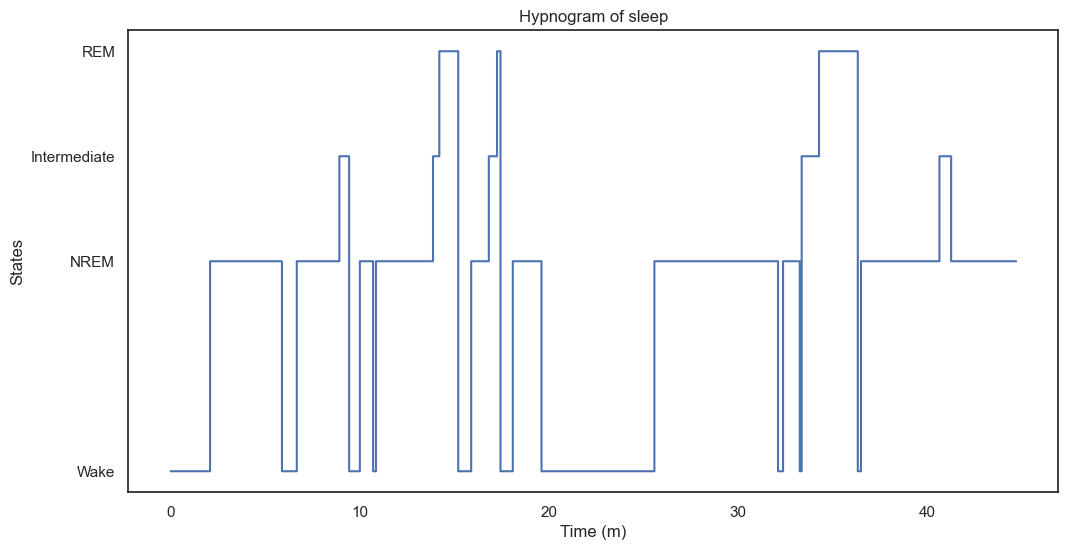

In [13]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)
lfpPFC, hypno_pfc, fs = get_data2(path_to_pfc, path_to_states)
plot_hypnogram(hypno)

In [14]:
np.unique(hypno)

array([1, 3, 4, 5], dtype=uint8)

In [15]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 2500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    # Apply a 900 ms duration threshold to phasic intervals
    phasic_interval = nap.IntervalSet(start, end)
    min_duration1 = 0.9  # 900 ms in seconds
    durations1 = phasic_interval['end'] - phasic_interval['start']
    valid_intervals1 = durations1 >= min_duration1
    phasic_interval = nap.IntervalSet(phasic_interval['start'][valid_intervals1], phasic_interval['end'][valid_intervals1])

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intervals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intervals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [16]:
t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

len(phasic_interval)

Number of detected Tonic intervals:5
Number of detected Tonic intervals after threshold:5


2

In [17]:
print([phasic_interval])

[  index    start      end
      0  2106.82  2111.89
      1  2140.09  2141.62
shape: (2, 2), time unit: sec.]


In [18]:
print([tonic_interval])

[  index    start      end
      0   853      912
      1  1036     1046
      2  2057     2106.82
      3  2111.89  2140.09
      4  2141.62  2179
shape: (5, 2), time unit: sec.]


In [19]:
intervals = [
    (853, 912),
    (1036, 1046),
    (2057, 2106.82),
    (2111.89, 2140.09),
    (2141.62, 2179)
]


def split_intervals(intervals, chunk=4, merge_threshold=2):
    result = []
    for start, end in intervals:
        cur = start
        L = end - start
        n_full = int(L // chunk)

        
        for _ in range(n_full):
            nxt = cur + chunk
            result.append([round(cur, 3), round(nxt, 3)])
            cur = nxt

        # remainder
        rem = end - cur
        if rem > 0:
            if rem < merge_threshold and result:
                result[-1][1] = round(end, 3)
            else:
                result.append([round(cur, 3), round(end, 3)])

    return np.array(result)

tonic_time = split_intervals(intervals)

In [20]:
print(len(tonic_time))

46


In [21]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [22]:
for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    print(signal1.size)

10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
7503
10004
10004
5002
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
14556
10004
10004
10004
10004
10004
10004
10504
10004
10004
10004
10004
10004
10004
10004
10004
13455


In [23]:
highsize = 14556

## Comparison

## Coherence

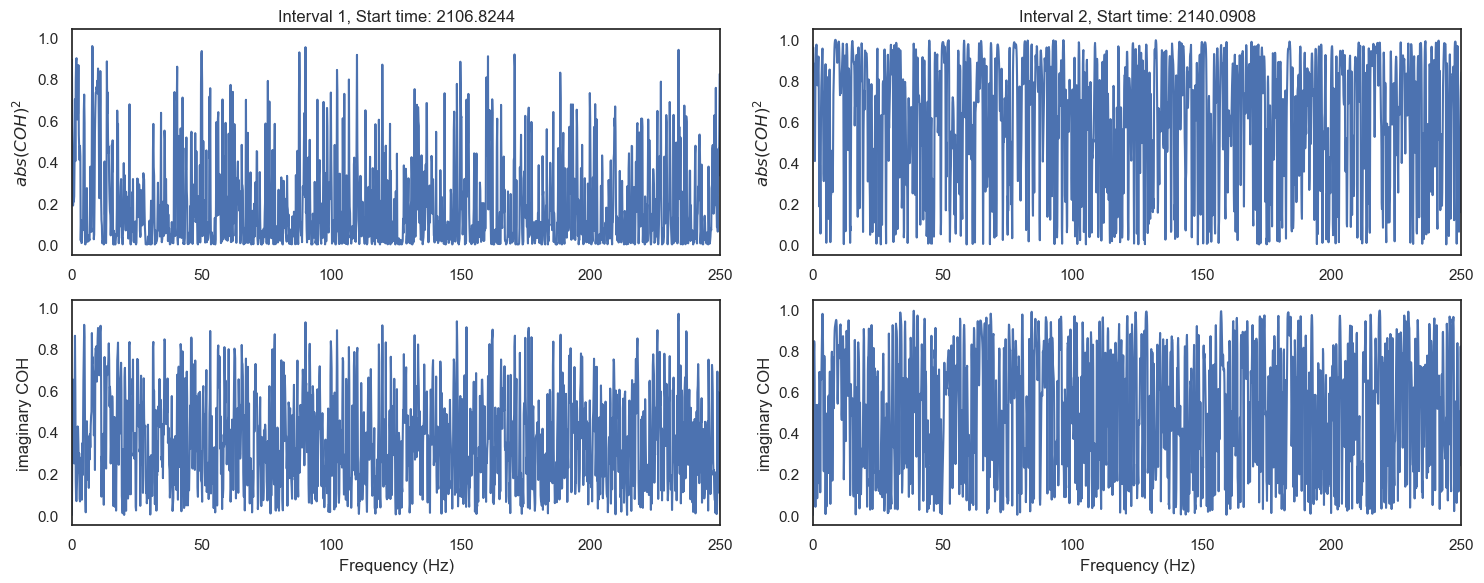

In [24]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[0,i].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0].set_xlim((0, multitaper.nyquist_frequency))
    axes[0,i].set_xlim((0, 250))
    axes[0,i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0,i].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1,i].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1,i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1,i].set_xlim((0, 250))
    #axes[1].set_title(f"Interval {i+1}")
    axes[1,i].set_xlabel('Frequency (Hz)')
    axes[1,i].set_ylabel('imaginary COH')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_coh_R4T4_HC.png")

mean coh: 0.5968152897116489 +/- 0.001965117573358207
mean icoh: 0.44591900060516015 +/- 0.0018654222026502324
mean coh: 0.5301649753823667 +/- 0.002448883172040912
mean icoh: 0.5794502866609101 +/- 0.0017821270629297655
mean coh: 0.5136526619402939 +/- 0.0023857894868162576
mean icoh: 0.49046222111316523 +/- 0.001704900208866899
mean coh: 0.4335871079177218 +/- 0.002288209917028778
mean icoh: 0.46525281159104 +/- 0.001862817938690067


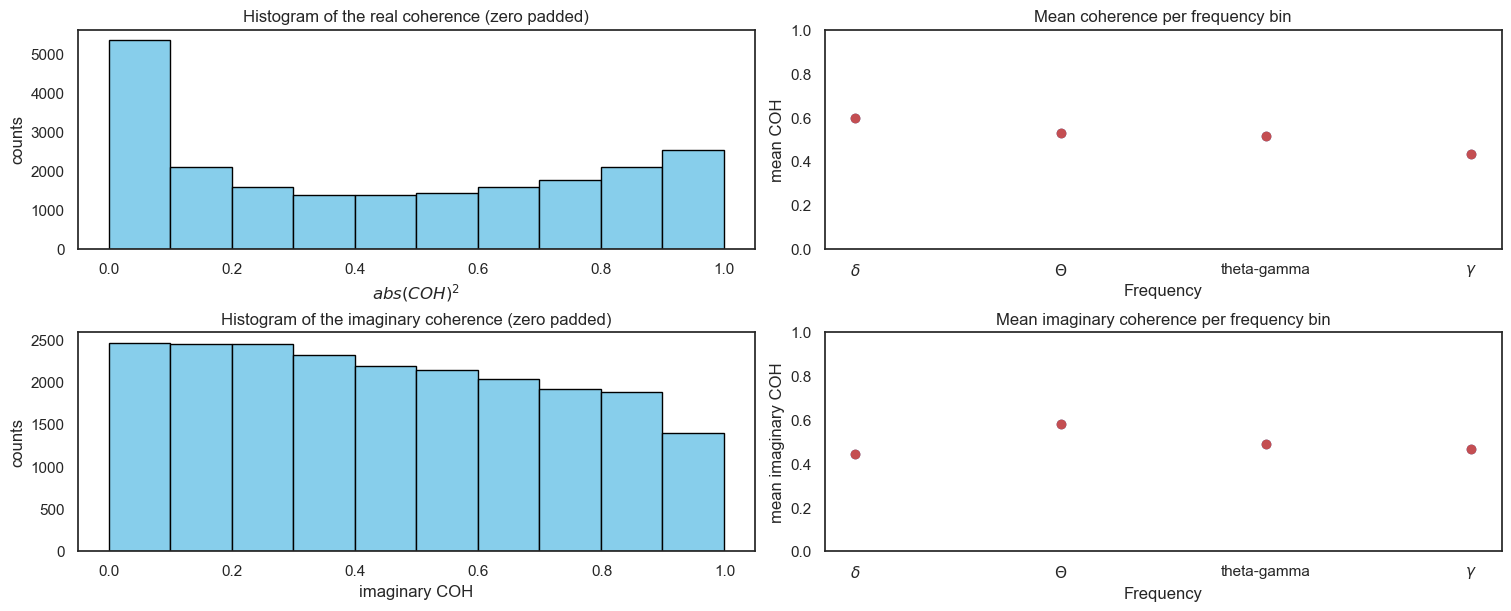

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$', '$\Theta$', 'theta-gamma', '$\gamma$']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_phasic = bin_means
mean_icoh_phasic = bin_means2
SEM_coh_phasic = error
SEM_icoh_phasic = error2

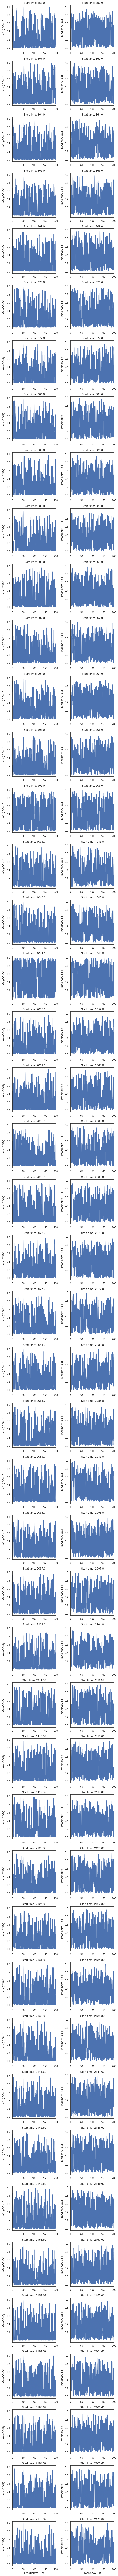

In [26]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 150), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    
    axes[i, 0].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i,0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i,1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('imaginary COH')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_coh_R4T4_HC.png")

mean coh: 0.25060017379477423 +/- 0.0003817833984790118
mean coh: 0.3189162198934087 +/- 0.00042027425833145117
mean coh: 0.25161178313692195 +/- 0.00037812268130163506
mean coh: 0.2260943686016468 +/- 0.00035952326163708287
mean icoh: 0.3771011309944837 +/- 0.0003486120111953139
mean icoh: 0.48889722229364047 +/- 0.00041067491531928817
mean icoh: 0.4157984962334255 +/- 0.00037675596945287295
mean icoh: 0.3704881347627923 +/- 0.0003611327394261072


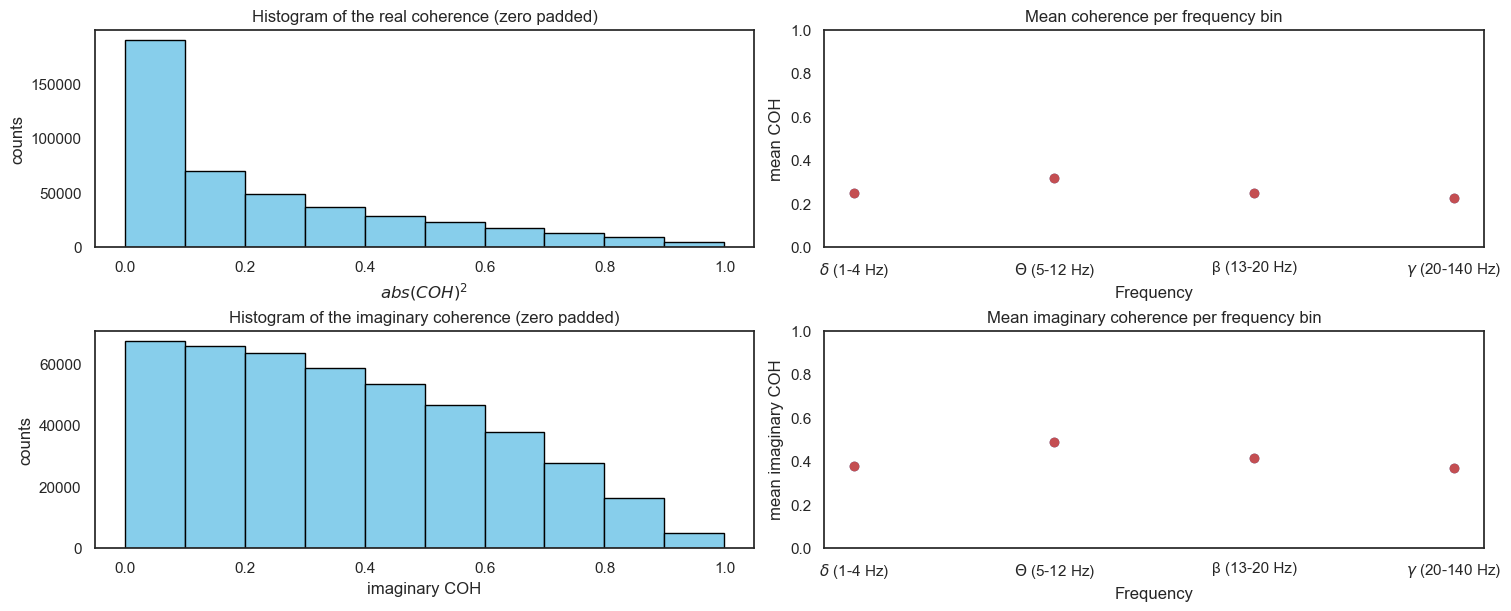

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_tonic = bin_means
mean_icoh_tonic = bin_means2
SEM_coh_tonic = error
SEM_icoh_tonic = error2

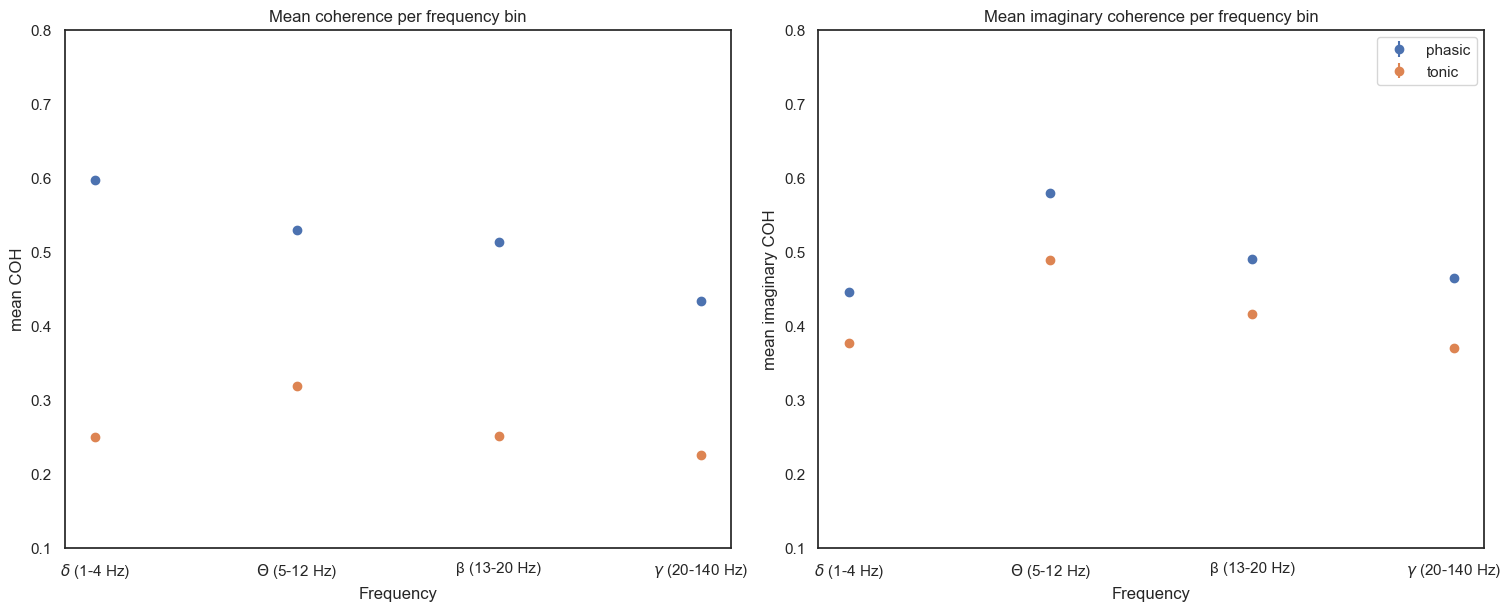

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_coh_phasic, yerr=SEM_coh_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_coh_tonic, yerr=SEM_coh_tonic, fmt="o", label='tonic')
axes[0].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean COH')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean coherence per frequency bin')

axes[1].errorbar(frequency_type, mean_icoh_phasic, yerr=SEM_icoh_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_icoh_tonic, yerr=SEM_icoh_tonic, fmt="o", label='tonic')
axes[1].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean imaginary COH')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean imaginary coherence per frequency bin')
plt.legend()

## Phase lag index

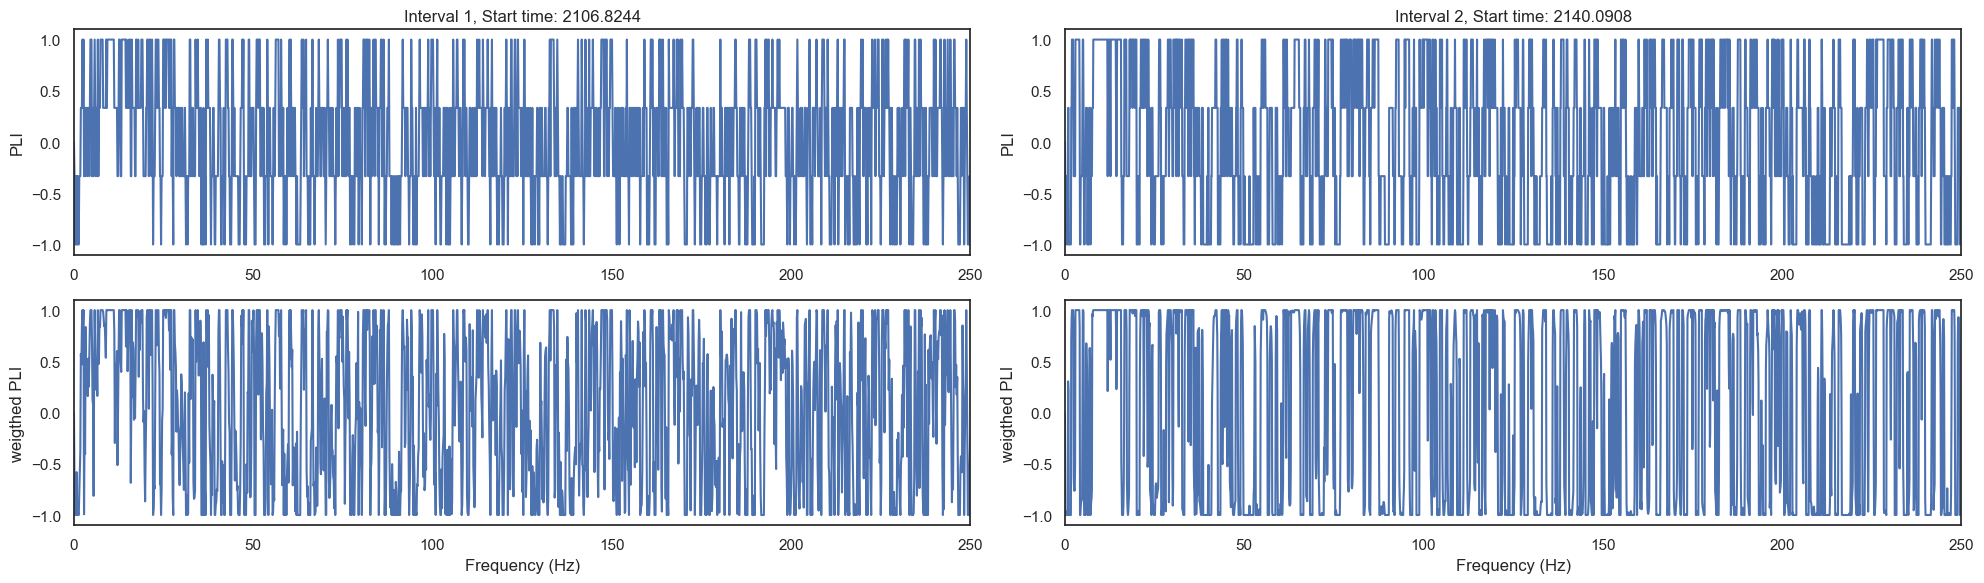

In [29]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0,i].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0,i].set_xlim((0, 250))
    axes[0,i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0,i].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1,i].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1,i].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1,i].set_xlabel('Frequency (Hz)')
    axes[1,i].set_ylabel('weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_pli_R4T4_HC.png")

mean pli: 0.1568627450980392 +/- 0.004938065127998433
mean pli: 0.534313725490196 +/- 0.004012644948329164
mean pli: 0.49717514124293777 +/- 0.004080195788674286
mean pli: 0.0009803921568627345 +/- 0.004665617027776684
mean wpli: 0.1377130811538562 +/- 0.005776122883147992
mean wpli: 0.6072349084674495 +/- 0.004420887262591556
mean wpli: 0.5793624175696349 +/- 0.004579755469757313
mean wpli: 0.01409528308215356 +/- 0.005762943218065705


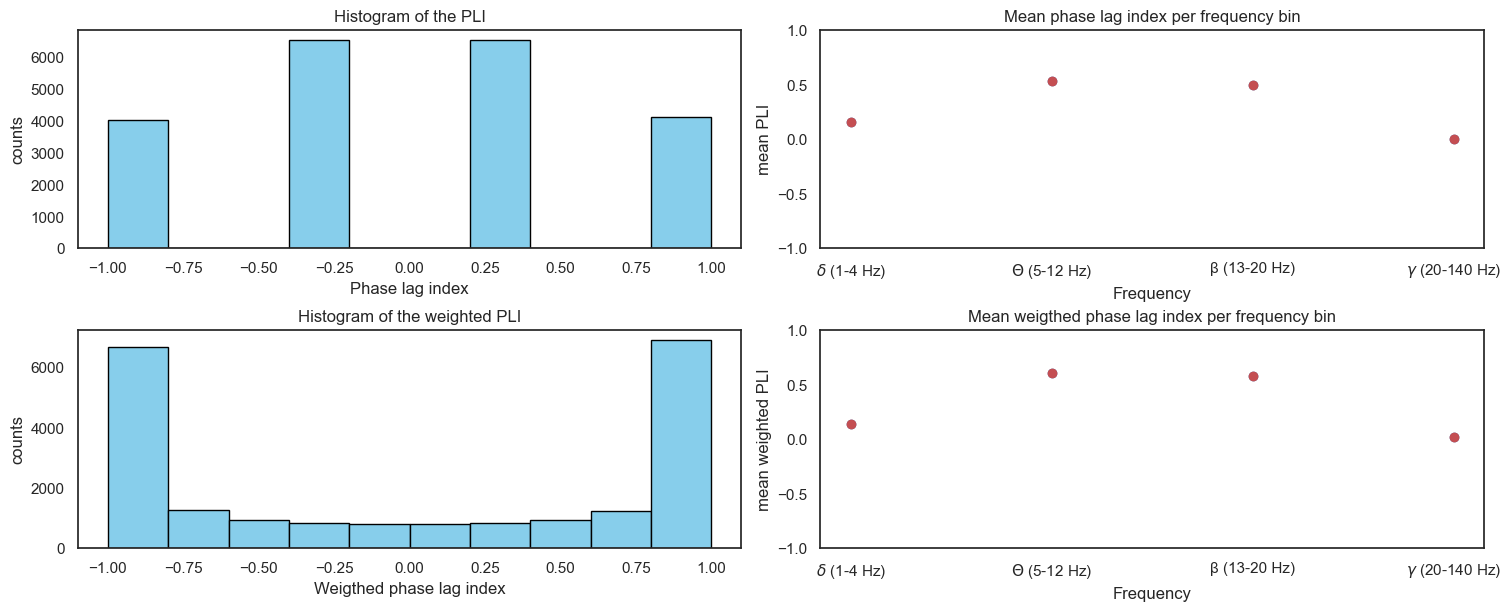

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_pli_phasic = bin_means
mean_wpli_phasic = bin_means2
SEM_pli_phasic = error
SEM_wpli_phasic = error2

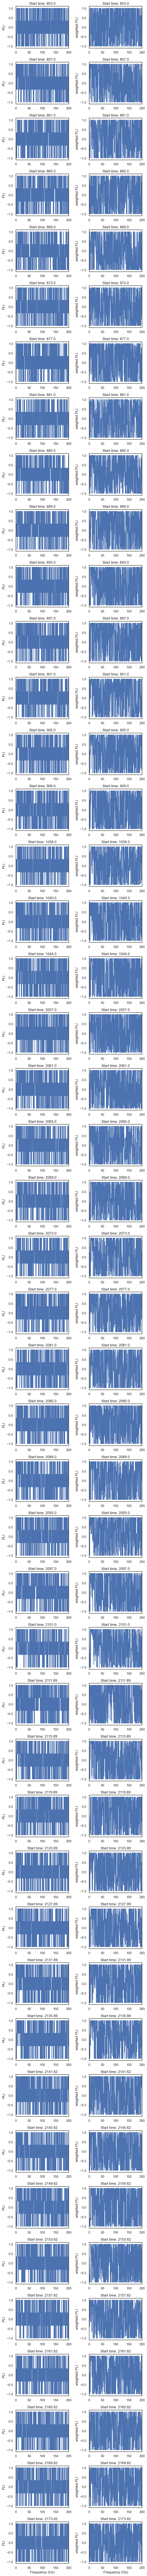

In [31]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7,120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted PLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_pli_R4T4_HC.png")

mean pli: -0.07958801498127334 +/- 0.000909495101742879
mean pli: 0.3853461584134918 +/- 0.0008658848771212973
mean pli: 0.2677419354838713 +/- 0.0008620175630561533
mean pli: 0.04424208109213211 +/- 0.0008933644028353522
mean wpli: -0.11860686401998988 +/- 0.0011263281225940905
mean wpli: 0.506310920706764 +/- 0.0009730071738230596
mean wpli: 0.36425875898113763 +/- 0.001035961654308673
mean wpli: 0.06259359173393786 +/- 0.001113486618461622


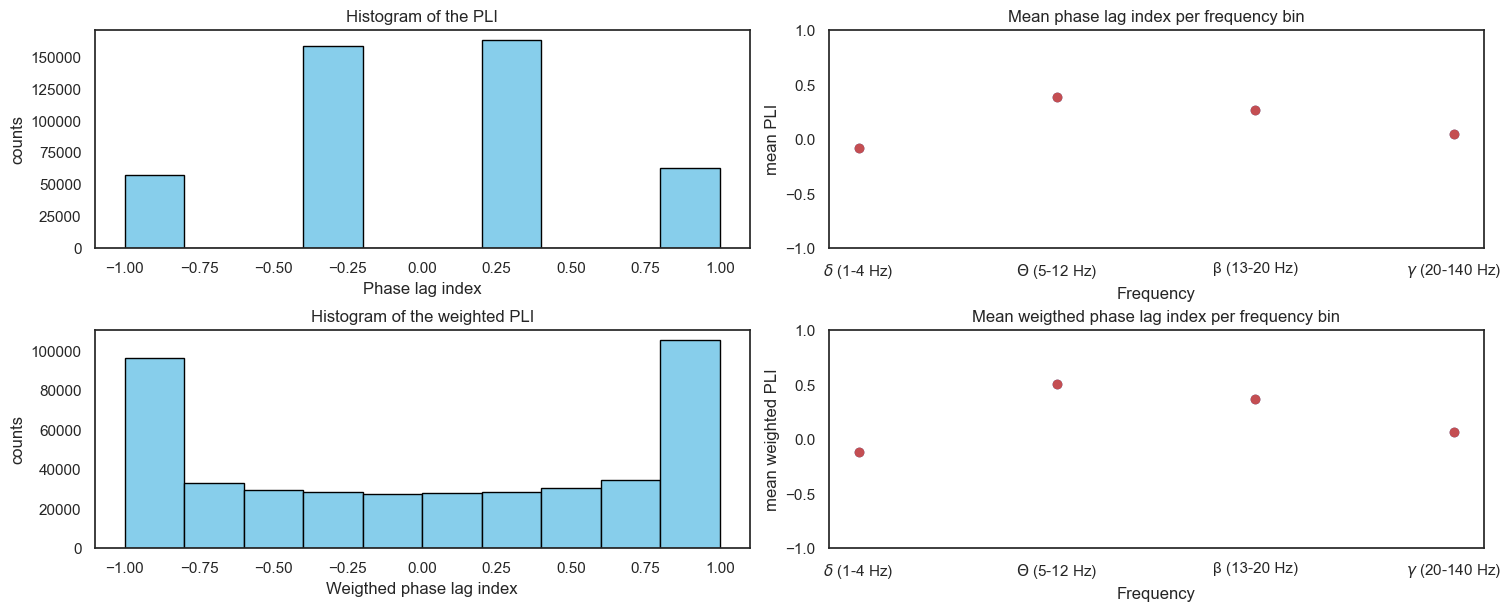

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_pli_tonic = bin_means
mean_wpli_tonic = bin_means2
SEM_pli_tonic = error
SEM_wpli_tonic = error2

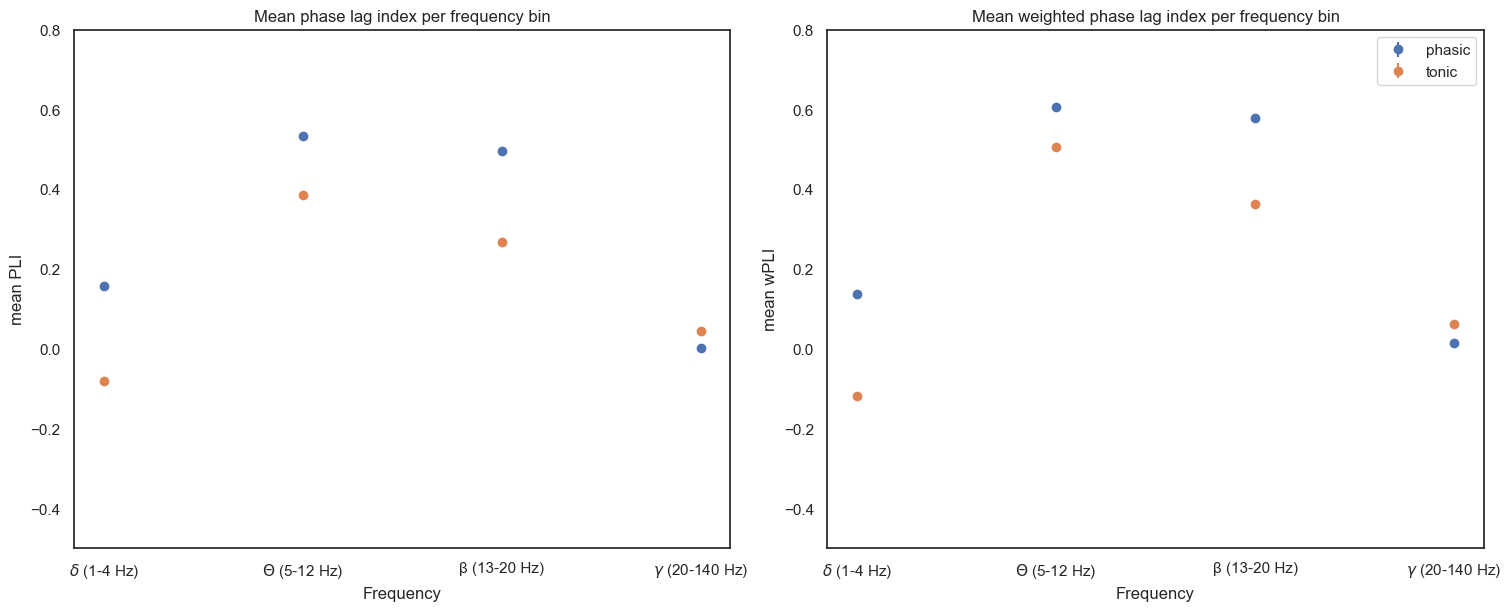

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_pli_phasic, yerr=SEM_pli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_pli_tonic, yerr=SEM_pli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean PLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean phase lag index per frequency bin')

axes[1].errorbar(frequency_type, mean_wpli_phasic, yerr=SEM_wpli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wpli_tonic, yerr=SEM_wpli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted phase lag index per frequency bin')
plt.legend()

## Debiased squared PLI

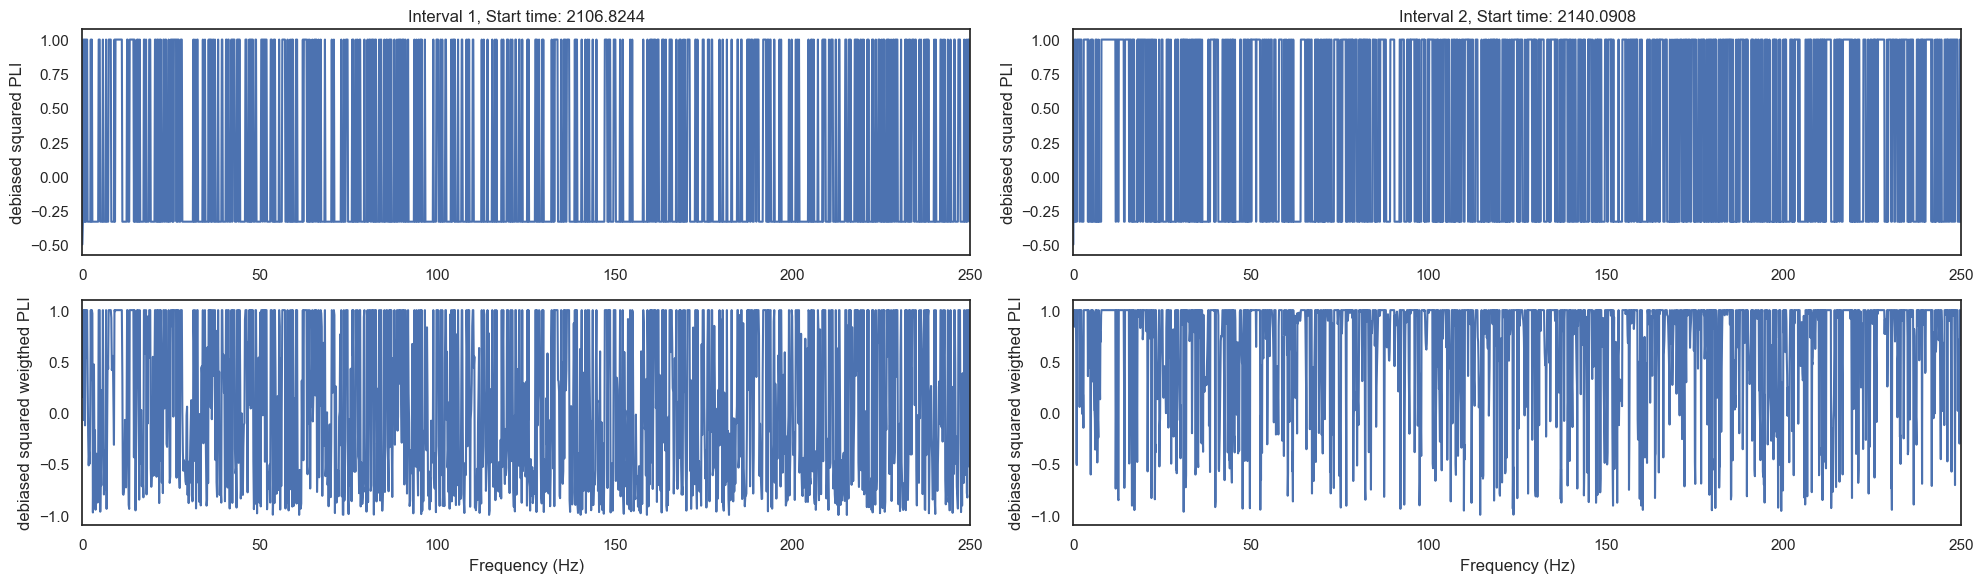

In [34]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0,i].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0,i].set_xlim((0, 250))
    axes[0,i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0,i].set_ylabel('debiased squared PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1,i].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1,i].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1,i].set_xlabel('Frequency (Hz)')
    axes[1,i].set_ylabel('debiased squared weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_dspli_R4T4_HC.png")

mean dspli: 0.31372549019607854 +/- 0.0045726083785466885
mean dspli: 0.44117647058823506 +/- 0.004514337176665167
mean dspli: 0.4011299435028245 +/- 0.0045508710955503625
mean dspli: 0.19346405228758268 +/- 0.004472773041931619
mean wdspli: 0.47438397975581925 +/- 0.004290388926291249
mean wdspli: 0.572089658466189 +/- 0.004317482348456292
mean wdspli: 0.5660875100062861 +/- 0.004443976843358338
mean wdspli: 0.4058479972067385 +/- 0.004689761818409511


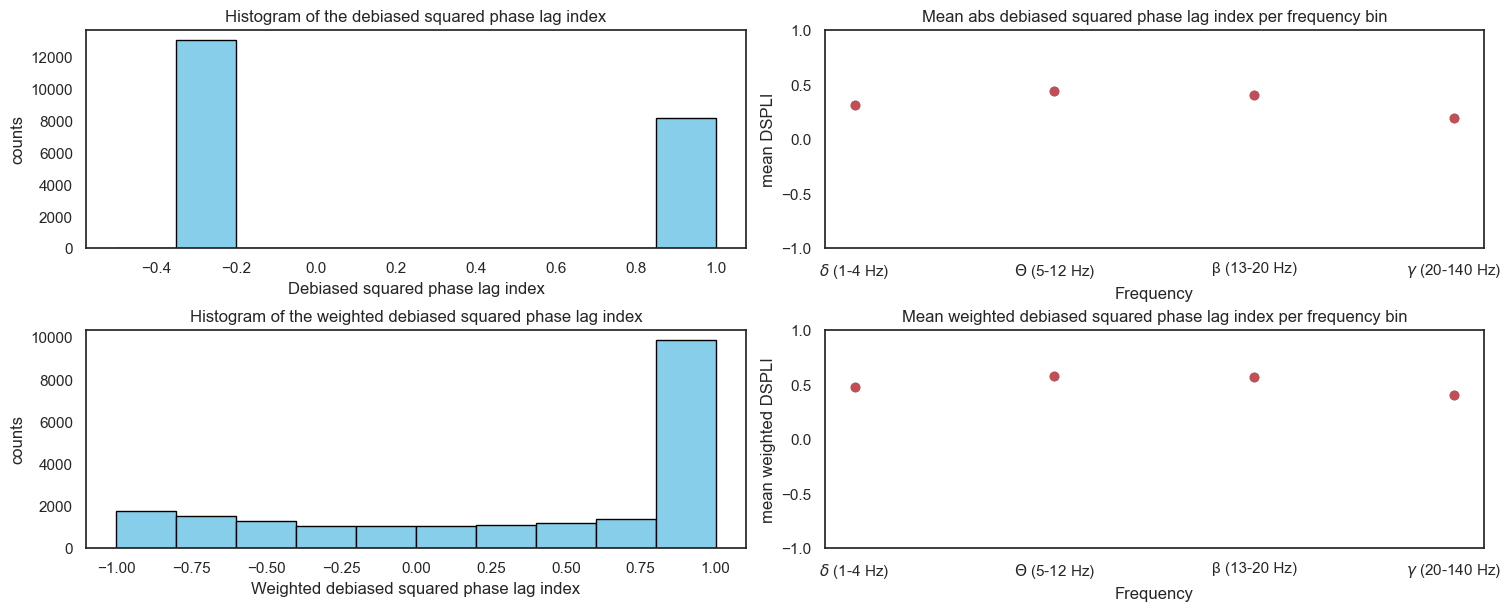

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_dspli_phasic = bin_means
mean_wdspli_phasic = bin_means2
SEM_dspli_phasic = error
SEM_wdspli_phasic = error2

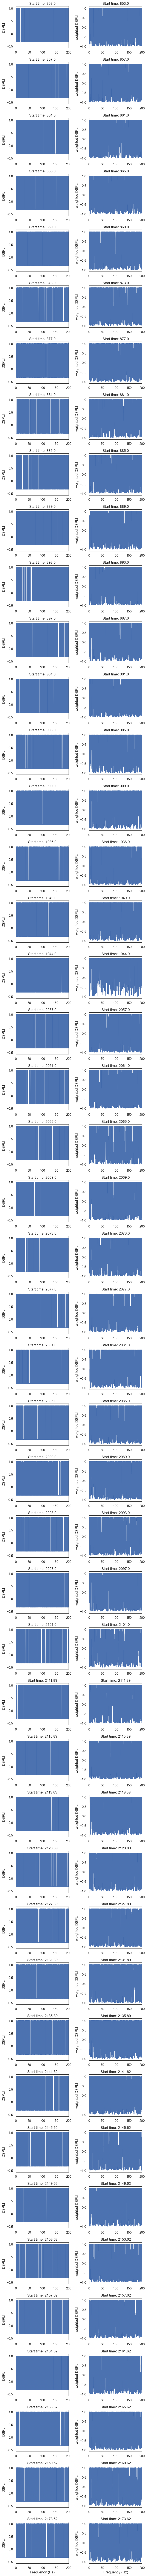

In [36]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
frequency_set2 = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('DSPLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    frequency_set2 = np.append(frequency_set2,connectivity.frequencies)
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted DSPLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_dspli_R4T4_HC.png")

mean dspli: 0.057116104868914504 +/- 0.0009133136418639563
mean dspli: 0.21909511934449427 +/- 0.0009886567196104837
mean dspli: 0.09946236559139604 +/- 0.0009397251199100366
mean dspli: 0.03129816614766292 +/- 0.0008946034881394017
mean wdspli: 0.07322861868076101 +/- 0.0011465712841037463
mean wdspli: 0.2936102047465223 +/- 0.0011358992681033103
mean wdspli: 0.1482393138066004 +/- 0.0011537199695327374
mean wdspli: 0.047606154905025705 +/- 0.0011384087350387144


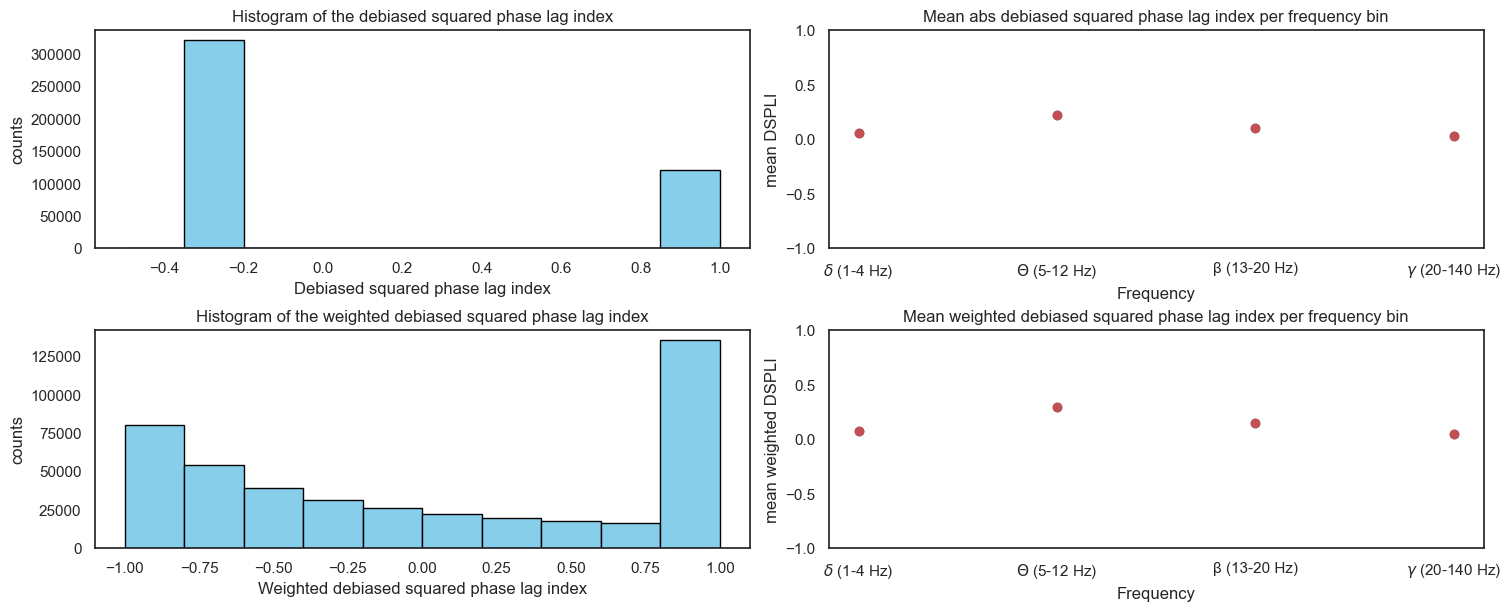

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_dspli_tonic = bin_means
mean_wdspli_tonic = bin_means2
SEM_dspli_tonic = error
SEM_wdspli_tonic = error2

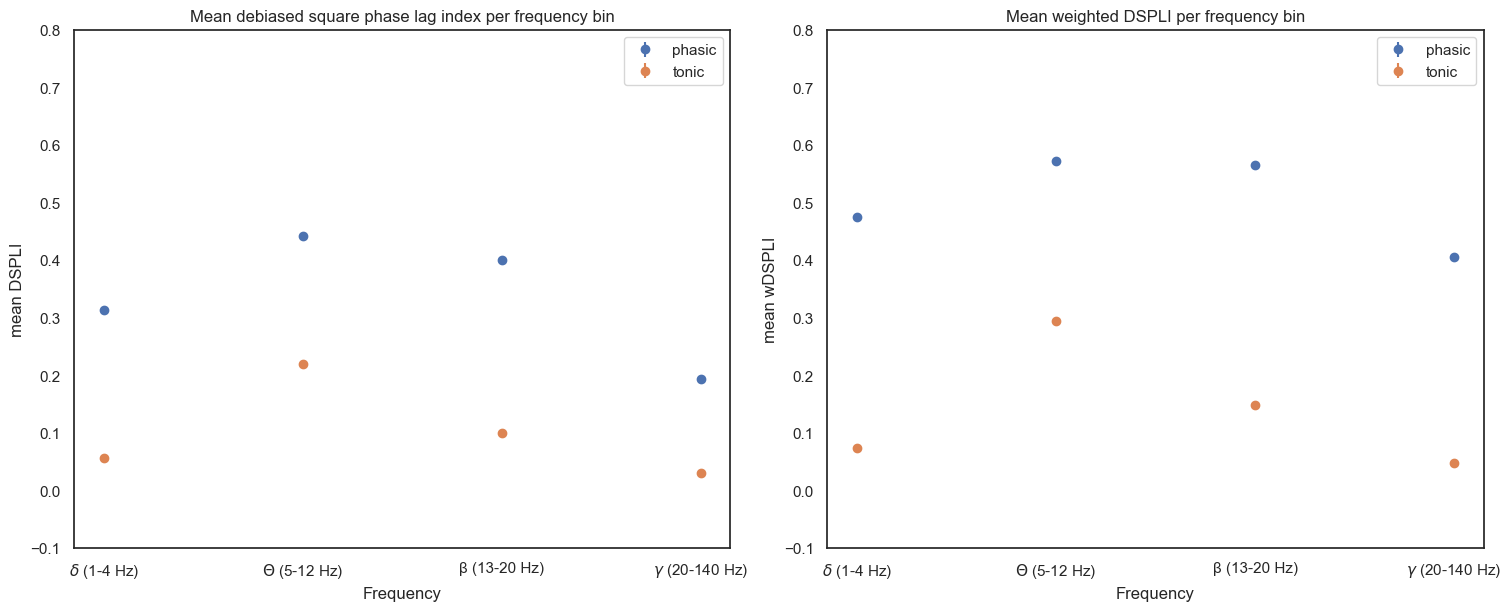

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_dspli_phasic, yerr=SEM_dspli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_dspli_tonic, yerr=SEM_dspli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean DSPLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean debiased square phase lag index per frequency bin')
axes[0].legend()

axes[1].errorbar(frequency_type, mean_wdspli_phasic, yerr=SEM_wdspli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wdspli_tonic, yerr=SEM_wdspli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wDSPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted DSPLI per frequency bin')
plt.legend()

## Pairwise phase consistency

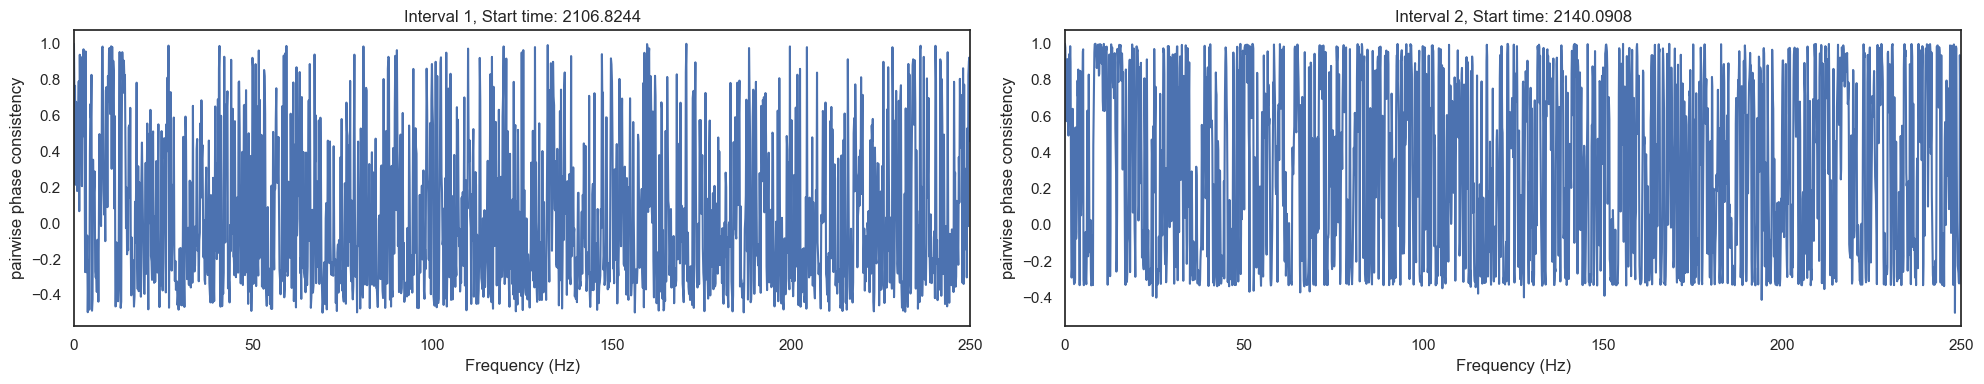

In [39]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    axes[i].plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i].set_xlim((0, 250))
    axes[i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('pairwise phase consistency')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_ppc_R4T4_HC.png")

mean ppc: 0.32925431636534425 +/- 0.0031361814542899464
mean ppc: 0.38971178871304724 +/- 0.0035700309417492845
mean ppc: 0.3554841025507318 +/- 0.003314751863041383
mean ppc: 0.18445546128212872 +/- 0.0031741318748857005


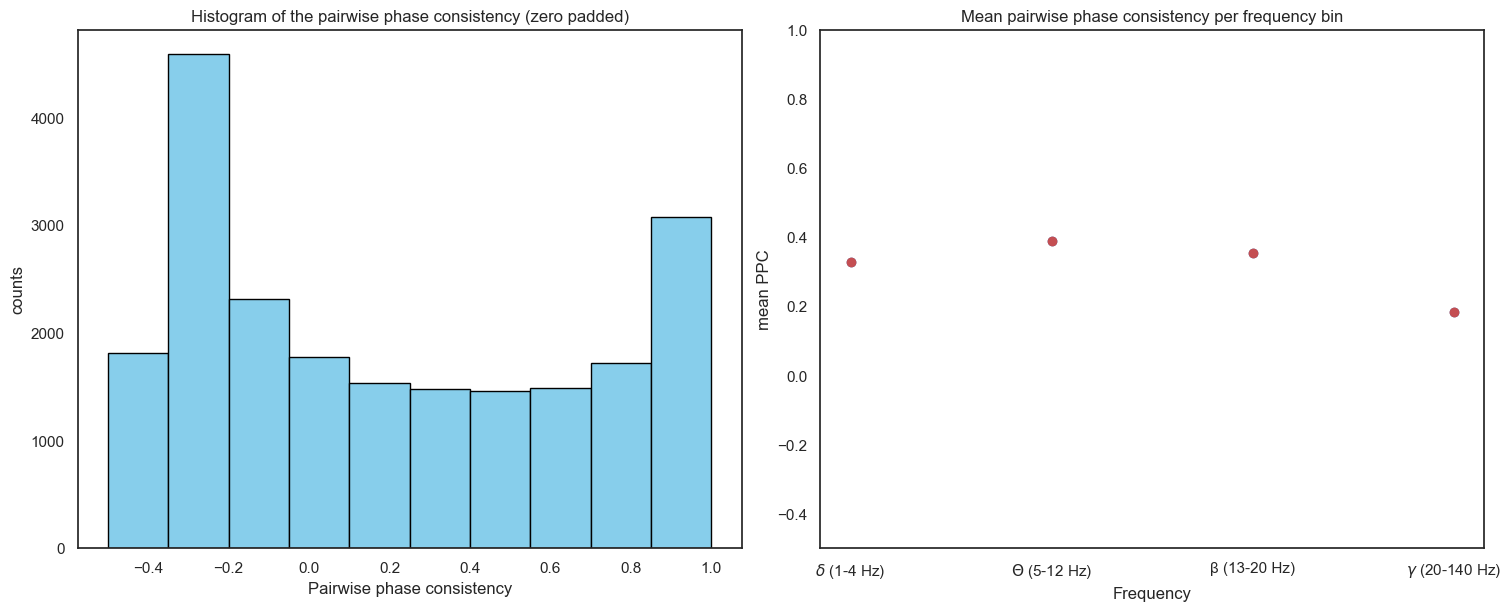

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_ppc_phasic = bin_means
SEM_ppc_phasic = error

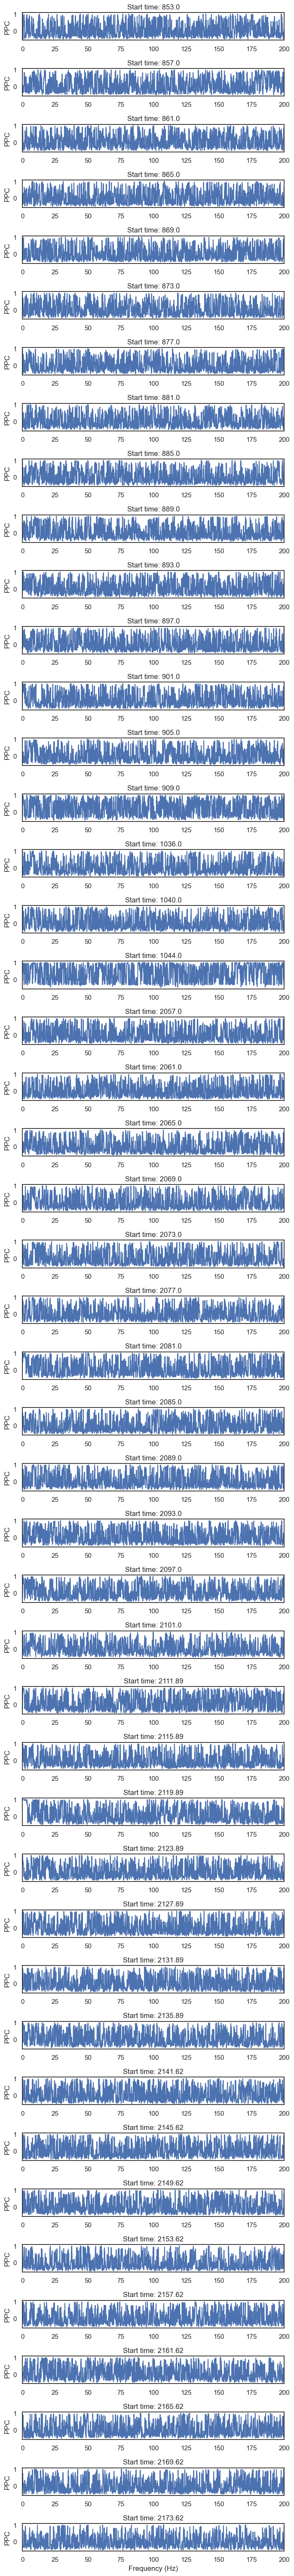

In [41]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=1, figsize=(7, 60), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    axes[i].plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i].set_xlim((0, 200))
    #axes[i].set_title(f"Interval {i+1}, real COH")
    axes[i].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PPC')

axes[len(tonic_time)-1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_ppc_R4T4_HC.png")

mean ppc: 0.09085366113061133 +/- 0.0006695223773666648
mean ppc: 0.1640326409309714 +/- 0.0007001272198264102
mean ppc: 0.0790578909366969 +/- 0.0006679377607532689
mean ppc: 0.043135551834543595 +/- 0.0006455898163191769


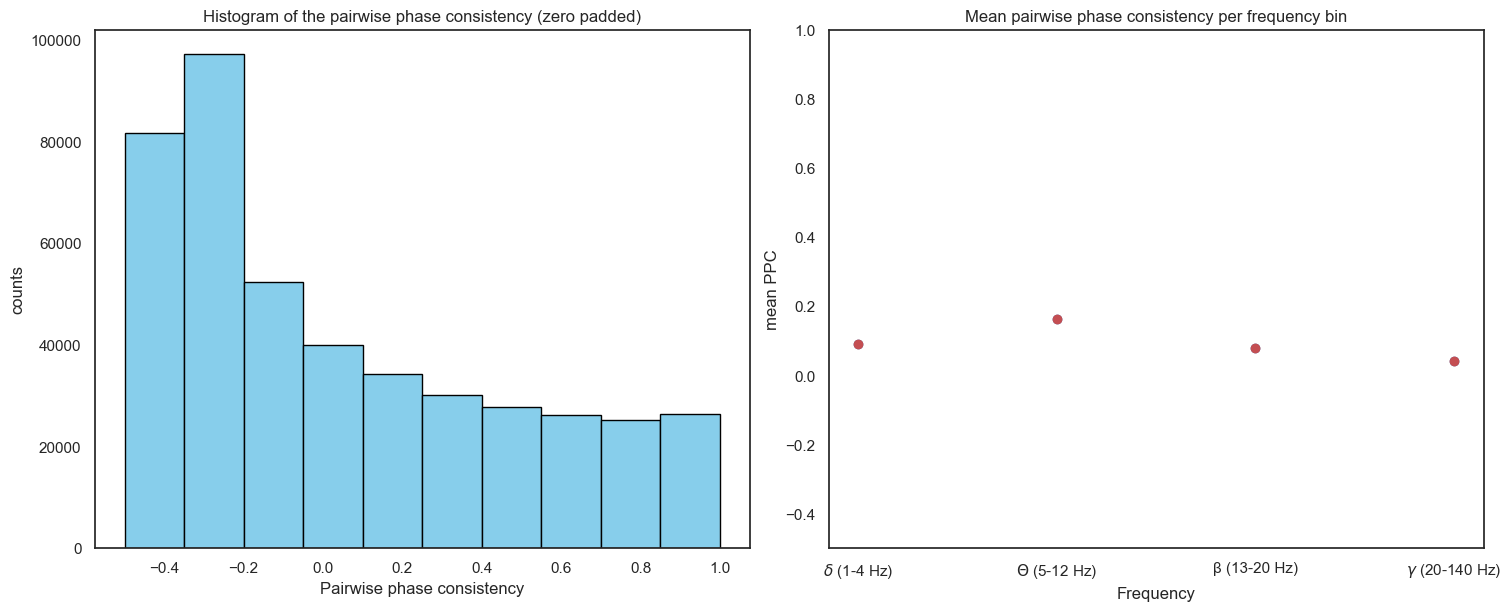

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_ppc_tonic = bin_means
SEM_ppc_tonic = error

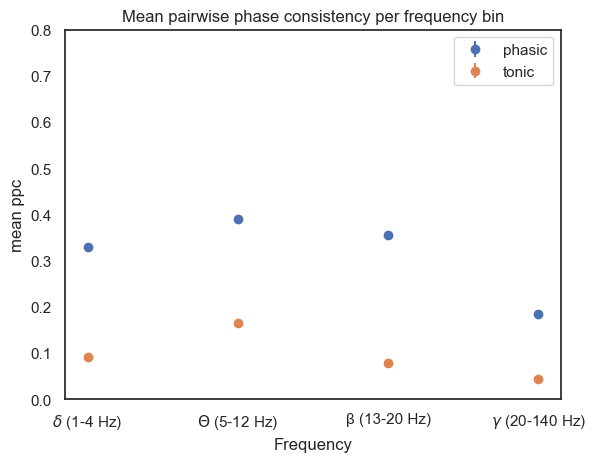

In [43]:
plt.errorbar(frequency_type, mean_ppc_phasic, yerr=SEM_ppc_phasic, fmt="o", label='phasic')
plt.errorbar(frequency_type, mean_ppc_tonic, yerr=SEM_ppc_tonic, fmt="o", label='tonic')
plt.ylim(0,0.8)
plt.ylabel('mean ppc')
plt.xlabel('Frequency')
plt.title('Mean pairwise phase consistency per frequency bin')
plt.legend()

## Table

In [44]:
mean_coh = np.hstack((mean_coh_phasic, mean_coh_tonic))
mean_icoh = np.hstack((mean_icoh_phasic, mean_icoh_tonic))
mean_pli = np.hstack((mean_pli_phasic, mean_pli_tonic))
mean_wpli = np.hstack((mean_wpli_phasic, mean_wpli_tonic))
mean_dspli = np.hstack((mean_dspli_phasic, mean_dspli_tonic))
mean_wdspli = np.hstack((mean_wdspli_phasic, mean_wdspli_tonic))
mean_ppc = np.hstack((mean_ppc_phasic, mean_ppc_tonic))

SEM_coh = np.hstack((SEM_coh_phasic, SEM_coh_tonic))
SEM_icoh = np.hstack((SEM_icoh_phasic, SEM_icoh_tonic))
SEM_pli = np.hstack((SEM_pli_phasic, SEM_pli_tonic))
SEM_wpli = np.hstack((SEM_wpli_phasic, SEM_wpli_tonic))
sem_dspli = np.hstack((SEM_dspli_phasic, SEM_dspli_tonic))
sem_wdspli = np.hstack((SEM_wdspli_phasic, SEM_wdspli_tonic))
SEM_ppc = np.hstack((SEM_ppc_phasic, SEM_ppc_tonic))

In [45]:
rows = []
for i in range(8):
    rows.append({
                    'COH': mean_coh[i],
                    'SE COH': SEM_coh[i],
                    'iCOH': mean_icoh[i],
                    'SE iCOH': SEM_icoh[i],
                    'PLI': mean_pli[i],
                    'SE PLI': SEM_pli[i],
                    'wPLI': mean_wpli[i],
                    'SE wPLI': SEM_wpli[i],
                    'DSPLI': mean_dspli[i],
                    'SE DSPLI': sem_dspli[i],
                    'wDSPLI': mean_wdspli[i],
                    'SE wDSPLI': sem_wdspli[i],
                    'PPC': mean_ppc[i],
                    'SE PPC': SEM_ppc[i]
                })
df = pd.DataFrame(rows, index = ["phasic delta", "phasic theta", "phasic theta-gamma", "phasic gamma", "tonic delta", "tonic theta", "tonic theta-gamma", "tonic gamma"])
df.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_R4T4_HC.csv', index=True)
df

COH    SE COH      iCOH   SE iCOH       PLI  \
phasic delta        0.596815  0.001965  0.445919  0.001865  0.156863   
phasic theta        0.530165  0.002449  0.579450  0.001782  0.534314   
phasic theta-gamma  0.513653  0.002386  0.490462  0.001705  0.497175   
phasic gamma        0.433587  0.002288  0.465253  0.001863  0.000980   
tonic delta         0.250600  0.000382  0.377101  0.000349 -0.079588   
tonic theta         0.318916  0.000420  0.488897  0.000411  0.385346   
tonic theta-gamma   0.251612  0.000378  0.415798  0.000377  0.267742   
tonic gamma         0.226094  0.000360  0.370488  0.000361  0.044242   

                      SE PLI      wPLI   SE wPLI     DSPLI  SE DSPLI  \
phasic delta        0.004938  0.137713  0.005776  0.313725  0.004573   
phasic theta        0.004013  0.607235  0.004421  0.441176  0.004514   
phasic theta-gamma  0.004080  0.579362  0.004580  0.401130  0.004551   
phasic gamma        0.004666  0.014095  0.005763  0.193464  0.004473   
tonic delta         0.000909 -0.118607  0.001126  0.057116  0.000913   
tonic theta         0.000866  0.506311  0.000973  0.219095  0.000989   
tonic theta-gamma   0.000862  0.364259  0.001036  0.099462  0.000940   
tonic gamma         0.000893  0.062594  0.001113  0.031298  0.000895   

                      wDSPLI  SE wDSPLI       PPC    SE PPC  
phasic delta        0.474384   0.004290  0.329254  0.003136  
phasic theta        0.572090   0.004317  0.389712  0.003570  
phasic theta-gamma  0.566088   0.004444  0.355484  0.003315  
phasic gamma        0.405848   0.004690  0.184455  0.003174  
tonic delta         0.073229   0.001147  0.090854  0.000670  
tonic theta         0.293610   0.001136  0.164033  0.000700  
tonic theta-gamma   0.148239   0.001154  0.079058  0.000668  
tonic gamma         0.047606   0.001138  0.043136  0.000646